In [2]:
import sys 
if '..' not in sys.path:
    sys.path.append('../')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import *
import matplotlib.pyplot as plt

folder_path = '/Users/antongolles/Documents/uni/masters/myMasters/applied_machine_learning/inertial_navigation_transformer/data/data_from_RoNIN/train_dataset_1/'

In [74]:
### Implement vanilla LSTM
## Set central parameters
# Set how many observations to combine into one datapoint
Ntrain = 5_000
Ntest = 2_500
num_datasets = 2
# set sequence length
seq_len = 10
random_start = True
# Set whether to include acceleration and magnetic data when training 
include_acc = True
include_ori = False
include_lin_acc = False#ue
include_mag = True
normalize=False
overlap = 0
# set whether to include truth data when training. 
# ... and to include the previous test prediction as the input when testing net batch
#use_truth_input = True
include_theta = True




Ntest_fraction = Ntest / Ntrain
# Decide which fraction of the training data should be used for validation
Nval_fraction = .2



input_features = ['synced/gyro']
output_features = ['pose/tango_pos']
if include_acc:
    input_features.append('synced/acce')
if include_mag:
    input_features.append('synced/magnet')
if include_lin_acc:
    input_features.append('synced/linacce')
if include_ori:
    output_features.append('pose/tango_ori')



params = {'N_train': Ntrain, 
        'N_test': Ntest,
        'seq_len': seq_len, 
        'input': input_features,
        'output': output_features, 
        'normalize': normalize,
        'verbose': False, 
        'num_datasets':num_datasets,
        'random_start':random_start,
        'overlap': overlap,
        'include_theta': include_theta,}
X_train, y_train, X_test, y_test, col_locations = load_split_data(folder_path=folder_path, **params)
print(col_locations)
print(X_train.shape)


using ['a017_1'] for testing and the remaining (2) for training
using 2 directories for training
test dirs: ['a017_1'] train dirs: ['a015_2', 'a011_3']
Loading a total of 5000, with 2500 points from each of 2 directories
a017_1
a015_2
dir: a015_2 is in train_dirs
a011_3
dir: a011_3 is in train_dirs
{'input': {'synced/gyro': (0, 3), 'synced/acce': (3, 6), 'synced/magnet': (6, 9), 'theta': (9, 25)}, 'output': {'pose/tango_pos': (0, 3)}}
(555, 10, 25)


In [75]:
d_model = 7
nhead = 2
dim_feedforward = 120
learning_rate = 0.001
num_epochs = 30
hidden_size = 64
batch_size = 1
num_layers = 3

# dataset
dataset_train = torch.utils.data.TensorDataset( torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float() )
# dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)


In [76]:
for x, y in dataloader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([1, 10, 25])
torch.Size([1, 10, 3])


In [88]:
# set up a tansformer model

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, batch_size, dropout=0.1):
        super().__init__()
        
        

        # Config variables
        self.d_model = 7
        self.nhead = 1
        self.num_layers = num_layers
        self.dim_feedforward = hidden_size * 4

        self.fc_get_next_quat = nn.Sequential(
            nn.Linear(4*4 + 4, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size*4),
            nn.ReLU(),
            nn.Linear(hidden_size*4, hidden_size*4),
            nn.ReLU(),
            nn.Linear(hidden_size*4, hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 4)
        )

        self.quat_cleaner = nn.Sequential(
            nn.Linear(13, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size*2),
            nn.ReLU(),
            
            nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            #nn.ReLU(),
            nn.Linear(hidden_size, 4)
        )

        #self.conv1 = nn.Conv1d(self.d_model, self.d_model, kernel_size=3, padding=1)

        self.transformer = nn.Transformer(d_model=self.d_model, nhead=self.nhead, num_encoder_layers=self.num_layers, num_decoder_layers=self.num_layers, dim_feedforward=self.dim_feedforward, dropout=dropout, batch_first=True)

        self.fc_out = nn.Sequential(
            nn.Linear(7, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size*2),
            #nn.ReLU(),
            #nn.Linear(hidden_size*2, hidden_size*4),
            #nn.ReLU(),
            #nn.Linear(hidden_size*4, hidden_size*4),
            #nn.ReLU(),
            #nn.Linear(hidden_size*4, hidden_size*2),
            #nn.ReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            #nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

        # set all the weights to be the same
        # for p in self.parameters():
        #     if p.dim() > 1:
        #         nn.init.xavier_uniform_(p)
        # #set all the weights to be 0
        # for p in self.parameters():
        #     p.data.fill_(0)
            

    def forward(self, x):
        # {'input': {'synced/gyro': (0, 3), 'synced/acce': (3, 6), 'synced/magnet': (6, 9), 'theta': (9, 25)}, 
        gyro =  x[:,:,0:3]
        magnet = x[:,:,3:6]
        acce = x[:,:,6:9]
        theta = x[:,:,9:25]

        # get initial orientation
        R = [get_body2world_rot(m[0].numpy(),a[0].numpy()) for m,a in zip(magnet, acce)]
        quat_start = [rotation_matrix_2_quaternion(np.linalg.inv(r)) for r in R]
        quat_start = torch.tensor(quat_start).float().squeeze().unsqueeze(0)
        quats = [quat_start]
        # get all the quaternions
        for i in range(1, len(theta[0])):
            quat = quats[i-1]
            theta_ = theta.squeeze()[i-1:i]#
            quat_next_ana = theta_.reshape(4,4) @ quat

            catted = torch.cat((quat_next_ana, theta_), dim=-1)
            next_quat = self.fc_get_next_quat(catted)
            # normalize the quaternion
            next_quat = next_quat / torch.norm(next_quat)
            quats.append(next_quat)
        quats = torch.stack(quats).squeeze().unsqueeze(0)
        #print(quats.shape)

        # clean quats 
        #print('quat shape', quats.shape, 'gyro shape', gyro.shape, 'acce shape', acce.shape, 'magnet shape', magnet.shape)
        quats = self.quat_cleaner(torch.cat((quats, gyro, acce, magnet), dim=2))
        quats = quats / torch.norm(quats)
        quats = quats.squeeze()
        # rotate the acce and magnet
        #print(acce.shape)
        acce_and_quat = torch.cat((acce.squeeze(), quats), dim=-1).unsqueeze(0)
        #print(acce_and_quat.shape)
        trans_out = self.transformer(acce_and_quat, acce_and_quat)
        #print(trans_out.shape)
        
        final_out = self.fc_out(trans_out)
        #print(final_out.shape)
        # select first 3 elements
        final_out = final_out[:,:,0:3]
        return final_out

# Training Loop
net = Net(input_size=X_train.shape[2], hidden_size=hidden_size, output_size=7, num_layers=num_layers, batch_size=batch_size)
optim_ = optim.AdamW(params=net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optim_, step_size=0.1, gamma=0.05) # Add a learning rate scheduler
criterion = nn.MSELoss()
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataloader:
        X_, y_ = data
        optim_.zero_grad()
        output =  net(X_)
        loss = criterion(output, y_)
        loss.backward()
        #nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)  # Uncommented gradient clipping
        optim_.step()
        scheduler.step()  # Added step for learning rate scheduler
        running_loss += loss.item()

    print(f'epoch: {epoch}, loss: {running_loss}')
    losses.append(running_loss)


# plot the losses
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
short_name = 'tiny'
plt.savefig(f'../figures/{short_name}_transformer_{d_model}_{nhead}_{num_layers}_{dim_feedforward}.png', dpi=300)

torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.Size([1, 16])
torch.Size([1, 4]) torch.

KeyboardInterrupt: 

In [86]:
X_test.shape

(277, 10, 25)

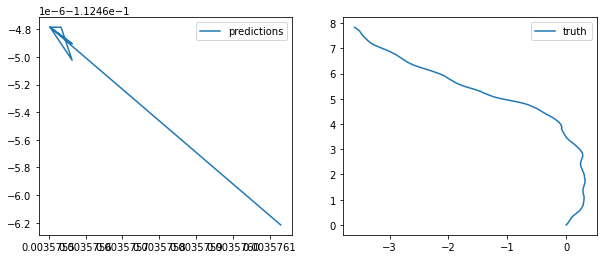

In [87]:
N_test = torch.from_numpy(X_test[:1]).float()

# set the model to evaluation mode
net.eval()

# make predictions
with torch.no_grad():
    predictions = net(N_test)

predictions = predictions.numpy()
accumulated_preds = []
for pred in predictions:
    accumulated_preds.append(pred + accumulated_preds[-1][-1] if accumulated_preds else pred)
predictions = np.array(accumulated_preds)
predictions = predictions.reshape(-1, 3)
# plot the predictions
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(predictions[:,0], predictions[:,1], label='predictions')
ax[0].legend()
y_test_reshaped = y_test.reshape(-1, 3)
y_test_reshaped -= y_test_reshaped[0]
ax[1].plot(y_test_reshaped[:,0], y_test_reshaped[:,1], label='truth')
ax[1].legend()

In [ ]:
# save the model
import datetime
timestamp_ = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
torch.save(net.state_dict(), f'../transformer_big_{timestamp_}.pt')

In [ ]:
# considering which free parameters there are
# 1. the number of layers in the encoder and decoder
# 2. the number of heads
# 3. the dimension of the model (but this is kinda fixed)
# 4. the dimension of the feedforward network
# 5. the dropout rate
# 6. the activation function
# 7. the custom encoder and decoder
# 8. the learning rate
# 9. the batch size